In [13]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import json
import zipfile
import os
import random
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
!pip install gdown
!gdown --id 1MhaG0zI4Zjt4ion5QXENwY8RK3YQfFOf

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14262 sha256=9265746f58716d039955776348db7b3b4070f453e8c35fcac3569c1416b5e7fb
  Stored in directory: /home/alfarizi/.cache/pip/wheels/2b/3c/51/52c46deda5cd1d59c6ce3d441ea5f3d155495dc294c4535a25
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1MhaG0zI4Zjt4ion5QXENwY8RK3YQfFOf
To: /home/alfarizi/Documents/college/data-mining/jurnal-resource/Dataset for Detection of Cyber-Trolls.json.zip
100%|████████████████████████████████████████| 686k/686k [00:00<00:00, 1.43MB/s]


In [16]:
def fetching_information_from_resource():
  # menentukan target file zip
  zip_file = 'Dataset for Detection of Cyber-Trolls.json.zip'
  extracting = zipfile.ZipFile(zip_file, 'r')

  # membuat directory dataset
  os.mkdir('dataset')
  dataset_dir = 'dataset'

  # extracting file zip
  extracting.extractall(dataset_dir)
  extracting.close()

  # membuat variabel untuk menampung dataset yang bertipe json
  target_file = os.path.join(dataset_dir, 'Dataset for Detection of Cyber-Trolls.json')
  json_file = pd.read_json(target_file, lines = True)

  general_datas = json_file['content']
  general_labels = []

  for index in range(len(general_datas)):
    general_labels.append(json_file['annotation'][index]['label'][0])

  indexes = list(range(len(general_labels)))

  random.shuffle(indexes)

  randomized_training_data = []
  randomized_training_label = []

  for index in indexes:
    randomized_training_data.append(general_datas[index])
    randomized_training_label.append(general_labels[index])

  return (randomized_training_data, randomized_training_label)

In [17]:
def tokenizing(datas, labels):
  VOCAB_SIZE = 1000
  tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token = '<OOV>')
  tokenizer.fit_on_texts(datas)
  word_index = tokenizer.word_index

  sequences = tokenizer.texts_to_sequences(datas)

  padded_sequences = pad_sequences(sequences, padding = 'post', maxlen = 100)

  integer_labels = [int(x) for x in labels]
  arrayed_labels = np.array(integer_labels)

  with open ('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  return (padded_sequences, arrayed_labels)

In [18]:
def splitting_dataset(datas, labels, TRAINING_PORTION):
  TRAINING_PORTION = 0.9

  training_datas = datas[:round(len(datas) * TRAINING_PORTION)]
  training_labels = labels[:round(len(datas) * TRAINING_PORTION)]
  validation_datas = datas[round(len(datas) * TRAINING_PORTION) :]
  validation_labels = labels[round(len(datas) * TRAINING_PORTION) :]

  return (training_datas, training_labels, validation_datas, validation_labels)

In [19]:
def generate_confusion_matrix(actual_label, predicted_label):
  matriks = tf.math.confusion_matrix(actual_label,predicted_label)
  print(matriks)

In [23]:
def training_model(training_data, training_label, validation_data, validation_label, model_filename, model_title):
  print("--- {} ---".format(model_title))

  model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(
        1000,
        500,
        input_length = 100
    ),
    tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(16)
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(25, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])

  model.compile(
    loss='binary_crossentropy',
    metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
  )

  history = model.fit(
    training_data, 
    training_label, 
    epochs = 10,
    validation_data = (validation_data, validation_label)
  )

  raw_predicted_label = model.predict(validation_data)
  predicted_label = []
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
  for label in raw_predicted_label:
    if label > 0.5:
      result = 1
    else:
      result = 0
    predicted_label.append(result)

  generate_confusion_matrix(validation_label, predicted_label)

  saved_model_path = './model/'+model_filename
  model.save(saved_model_path)

  return model, history

In [21]:
def undersampling_dataset(training_datas, training_labels):
  # cari kelas mayoritas
  true_count = 0
  false_count = 0

  for index in range(len(training_datas)):
    if training_labels[index] == 0:
      false_count += 1
      training_labels[index] = 0
    elif training_labels[index] == 1:
      true_count += 1
      training_labels[index] = 1

    if true_count > false_count:
      majority_class = 1
    else:
      majority_class = 0

    # masukin index data yang kelas mayoritas ke majority_indexes, sekaligus inisialisasi balanced datas dan labels
  majority_indexes = []
  balanced_datas = []
  balanced_labels = []

  for index in range(len(training_datas)):
    if training_labels[index] == majority_class:
      majority_indexes.append(index)
    else:
      # balanced datas dan balanced labels akan diisi sama kelas minoritas dulu
      balanced_datas.append(training_datas[index])
      balanced_labels.append(training_labels[index])

  # randmon index dari kelas majoritas, agar yang di undersampling data acak (tidak berurutan)
  random.shuffle(majority_indexes)

  # memasukan data dari kelas mayoritas ke balanced_datas dan balanced_labels dengan banyak data setara dengan data minoritas
  balancing_point = len(balanced_datas)

  for index in range(balancing_point):
    majority_index = majority_indexes[index]

    balanced_datas.append(training_datas[majority_index])
    balanced_labels.append(training_labels[majority_index])

  # random data yang sudah balance
  indexes = list(range(len(balanced_datas)))

  random.shuffle(indexes)

  randomized_training_data = []
  randomized_training_label = []

  for index in indexes:
    randomized_training_data.append(balanced_datas[index])
    randomized_training_label.append(balanced_labels[index])

  return (np.array(randomized_training_data), np.array(randomized_training_label))

In [22]:
def loadingResources():
    imbalanced_model = tf.keras.models.load_model('unbalanced_model.h5')
    balanced_model = tf.keras.models.load_model('balanced_model.h5')
    
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    return (imbalanced_model, balanced_model, tokenizer)

In [48]:
def drawComparedGraph(epochs, imbalanced_metrics, balanced_metrics, param):
    plt.plot(epochs, imbalanced_metrics, 'r', label=(param + ' (Imbalanced)'))
    plt.plot(epochs, balanced_metrics, 'b', label=(param + ' (Balanced)'))
    plt.title('Imbalanced VS Balanced Data on ' + param)
    plt.legend(loc=4)
    plt.show()

In [73]:
def createCSV(history, filename, balanced):
    content = []
    metrics = ['accuracy', 'val_accuracy', 'recall', 'val_recall', 'precision', 'val_precision']
    cols = ['epochs', 'accuracy', 'val_accuracy', 'recall', 'val_recall', 'precision', 'val_precision']
    
    for index in range(len(history.history['accuracy'])):
        list_value = []
        list_value.append(index+1)
        if balanced:
            for metric in metrics:
                if 'accuracy' in metric:
                    list_value.append(round(history.history[metric][index], 4))
                else:
                    list_value.append(round(history.history[metric+'_1'][index], 4))
        else:
            for metric in metrics:
                list_value.append(round(history.history[metric][index], 4))
        
        content.append(list_value)
    results = pd.DataFrame(
        content,
        columns=cols
    )
    results.to_csv(filename, index=False)
    
    print('success generate '+filename)

In [25]:
(general_datas, general_labels) = fetching_information_from_resource()

(tokenized_datas, arrayed_labels) = tokenizing(general_datas, general_labels)

(
    training_datas, 
    training_labels, 
    validation_datas, 
    validation_labels
) = splitting_dataset(tokenized_datas, arrayed_labels, 0.9)
(unbalanced_model, unbalanced_history) = training_model(training_datas, training_labels, validation_datas, validation_labels, 'unbalanced_model.h5', 'UNBALANCED MODEL')
print()
print()
(balanced_datas, balanced_labels) = undersampling_dataset(tokenized_datas, arrayed_labels)

(balanced_model, balanced_history) = training_model(balanced_datas, balanced_labels, validation_datas, validation_labels, 'balanced_model.h5', 'BALANCED MODEL')

--- UNBALANCED MODEL ---


2021-10-23 19:16:38.486746: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
563/563 [==============================] - 89s 145ms/step - loss: 0.5339 - accuracy: 0.7038 - recall: 0.5617 - precision: 0.6386 - val_loss: 0.4701 - val_accuracy: 0.7550 - val_recall: 0.6878 - val_precision: 0.6808
Epoch 2/10
563/563 [==============================] - 86s 152ms/step - loss: 0.4419 - accuracy: 0.7739 - recall: 0.7224 - precision: 0.7068 - val_loss: 0.4443 - val_accuracy: 0.7675 - val_recall: 0.7358 - val_precision: 0.6852
Epoch 3/10
563/563 [==============================] - 82s 146ms/step - loss: 0.3858 - accuracy: 0.8166 - recall: 0.7872 - precision: 0.7550 - val_loss: 0.4311 - val_accuracy: 0.7880 - val_recall: 0.7953 - val_precision: 0.6977
Epoch 4/10
563/563 [==============================] - 79s 141ms/step - loss: 0.3301 - accuracy: 0.8530 - recall: 0.8323 - precision: 0.8003 - val_loss: 0.4198 - val_accuracy: 0.8005 - val_recall: 0.8433 - val_precision: 0.7008
Epoch 5/10
563/563 [==============================] - 84s 149ms/step - loss: 0.2736 - accura

In [27]:
imbalanced_model, balanced_model, loaded_tokenizer = loadingResources()

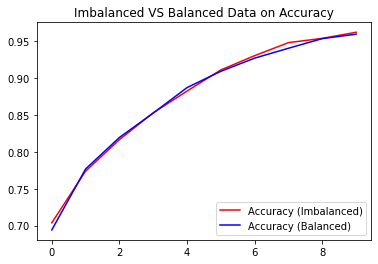

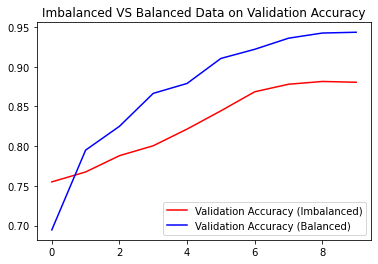

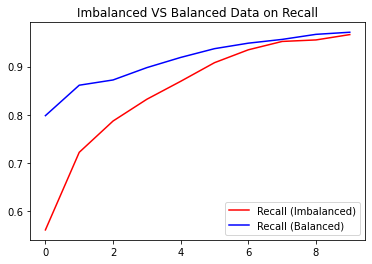

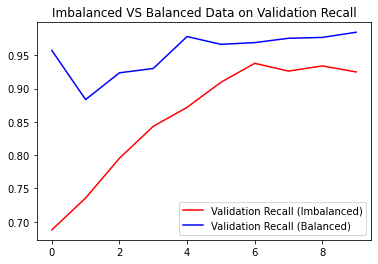

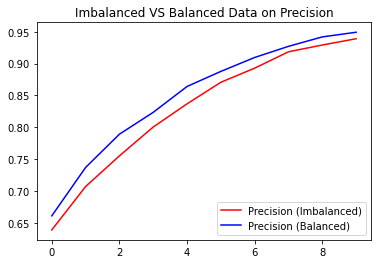

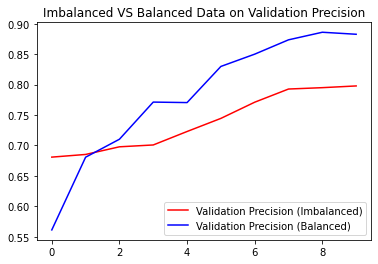

In [52]:
results = ['accuracy', 'val_accuracy', 'recall', 'val_recall', 'precision', 'val_precision']
params = ['Accuracy', 'Validation Accuracy', 'Recall', 'Validation Recall', 'Precision', 'Validation Precision']

for index in range(len(results)):
    unbalanced_metrics = unbalanced_history.history
    balanced_metrics = balanced_history.history
    current_result = results[index]
    current_label = params[index]
    epochs = range(len(unbalanced_metrics[current_result]))
    
    if 'accuracy' in current_result:
        drawComparedGraph(epochs, unbalanced_metrics[current_result], balanced_metrics[current_result], current_label)
    else:
        drawComparedGraph(epochs, unbalanced_metrics[current_result], balanced_metrics[current_result+'_1'], current_label)

In [74]:
createCSV(unbalanced_history, 'imbalanced_result.csv', False)
createCSV(balanced_history, 'balanced_result.csv', True)

success generate imbalanced_result.csv
success generate balanced_result.csv
